# Filtering the data

This notebook gives an example of how to pre-filter your raw Ct data. The `qpcr` module contains the `qpcr.Filters` submodule which defines two types of filters: the `RangeFilter` and the `IQRFilter`. Both of these vet input data and remove any (probably) faulty meaurements. This keeps your data clean and ensures the datafiles themselves are still left intact. 

#### Experimental background

The corresponding experimental setup was as follows: 
Levels of Nonsense-mediated mRNA decay (NMD) sensitive (nmd) and insensitive (prot) transcript isoforms of HNRNPL and SRSF11 were measured by qPCR. As normalisers both 28S rRNA and Actin transcript levels were measured. The replicates are biological triplicates and technical douplicates. All measurements from the same qPCR sample were merged into hexaplicates (6 replicates). This was done in two separate HeLa cell lines (one with a specific gene knockout (KO), and one without (WT)), which were both treated to a plasmid-mediated rescue (+) or not (-), leading to four experimental conditions:

| cell line \\ condition | rescue | no rescue |
| ---------------------- | ------ | --------- |
| knockout               | KO+    | KO-       |
| wildtype               | WT+    | WT-       |



#### Simple Analysis
In this example we will perform the same basic Delta-Delta Ct analysis, we did in the previous tutorials. However, this time we will add a `RangeFilter` to our analysis. 

What the `RangeFilter` does is pretty self-explanatory from its name. It filters out any data point that is outside a given range around the median of a group of replicates (per default settings `+/- 1` around the `median`, but both range and anchor can be manually adjusted).

The handy thing is that, just like `Plotters`, the `BasicPlus` pipeline also supports adding in `Filters`. However, we will also discuss how to manually use filters when building your pipeline.

In [1]:
# import what we need
import qpcr
from qpcr.Pipes import BasicPlus
from qpcr.Filters import RangeFilter, IQRFilter

We will setup the data right at the start so that's out of the way. We have discussed the way to provide data to either the classes of the main `qpcr` module or the `qpcr.Pipes` pipelines in the last tutorials. If any of these steps are unclear to you, please, check out the previous tutorials.

In [2]:
# get our datafiles
normaliser_files = [
                        "./Example Data/28S.csv",
                        "./Example Data/actin.csv"
                ]

sample_files = [
                    "./Example Data/HNRNPL_nmd.csv",
                    "./Example Data/HNRNPL_prot.csv",
                    "./Example Data/SRSF11_nmd.csv",
                    "./Example Data/SRSF11_prot.csv",
            ]

# define our experimental parameters
reps = 6
group_names = ["WT-", "WT+", "KO-", "KO+"] 

Tutorial 1 - Filters and the `BasicPlus` pipeline
---

### 1.1 Setting up the `BasicPlus` pipeline
We already discussed setting up a pipeline in the [previous tutorial](https://qpcr.readthedocs.io/en/latest/tutorials/2_pipeline_tutorial.html) so we will not go over the details here again.

In [3]:
# setup the pipeline
pipeline = BasicPlus()

### 1.3 Adding the `RangeFilter`
That's the moment we have been waiting for. We can add the `RangeFilter` just like we just added the `PreviewResults` figure class. The procedure is absolutely identical.

Filters can not only filter out faulty data points but they also generate a report about their work, recording which entries they removed, and under which settings they were run. 
Also, they support visualising the data that passed through them before and after filtering using `BoxPlots`. The filter we define below will generate a static boxplot summary of its filtering-activity.

In [4]:
# setup the filter
filter = RangeFilter()
pipeline.add_filters(filter)

### 1.4 Feeding our data
Next we feed our pipeline with our experimental data. 

In [5]:
pipeline.replicates(reps)
pipeline.names(group_names)
pipeline.add_assays(sample_files)
pipeline.add_normalisers(normaliser_files)

### 1.5 Running everything
Now that we are all set up, we are ready to go and run the pipeline.

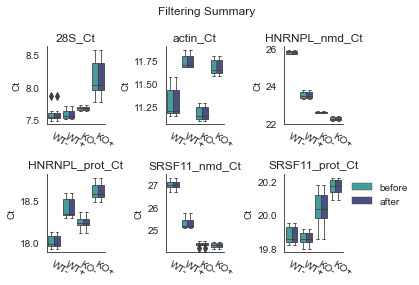

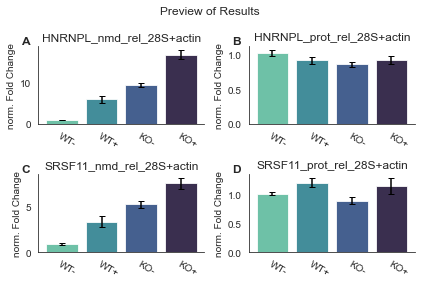

In [6]:
# run the pipeline
pipeline.run()

# and get results
results = pipeline.results()
fig = results.preview()

Notice how our filtering did not actually remove any data points. This is because even though some data points are considered outliers when visualising the data in box plots, they still all lie within the static inclusion range. To remove these data points, we can either define a narrower inclusion range using the filter's `set_lim()` method, or choose the `IQRFilter` instead of the static `RangeFilter`. 

Tutorial 2 - Manual use of Filters
---

We have already seen how to manually implement an analysis pipeline in the first tutorial in `1_manual_tutorial.ipynb`. 

The filter is simply one more step we can implement after reading the data and before performing the first $\Delta Ct$ computation. Conveniently, just like the `qpcr.Analyser`, the `qpcr.Filters` also are equipped with a `pipe()` method that takes in a `qpcr.Assay` object and returns the same containing only entries that passed the filter. However, again, we don't have to bother with manually setting up a filter, but can make use of the `qpcr.filter` function if default settings are good enough.

### 2.1 Setting up the `IQRFilter`
Now this time we actually use the `IQRFilter` instead of the `RangeFilter`. 
We later want to generate a summary figure to check if any replicates were removed during filtering. The Filters support plotting using the `qpcr.plot` function or their own dedicated `plot` method.

In [7]:
iqrfilter = IQRFilter()

### 2.3 Assembling the pipeline and including the `Filter`
Now we are ready to assemble our pipeline again. We can simply reuse the setup from the first tutorial and add the filter between the `DataReader`'s `read()`-step and the `Analyser`'s `pipe()`-step.

In [8]:
# now feed in our data

# we first deal with the normalisers 28S and actin
normalisers = qpcr.read(normaliser_files, replicates=reps, names=group_names)
    
# here we filter our data
normalisers = iqrfilter.pipe(normalisers)

# and now we compute Delta-Ct
normalisers = qpcr.delta_ct(normalisers)

# and we do the same for our assays-of-interest of HNRPL and SRSF11
assays = qpcr.read(sample_files, replicates=reps, names=group_names)
assays = iqrfilter.pipe(assays)
assays = qpcr.delta_ct(assays)

### 2.4 Generate the Filtering Summary
The Boxplots from filtering must be made **after** all the filtering is done (otherwise it wouldn't be much of a _summary_). Therefore, we can call the filter's `plot()` method at basically any point after we have finished with the last `qpcr.Analyser`-step. To do this all we need to call is:

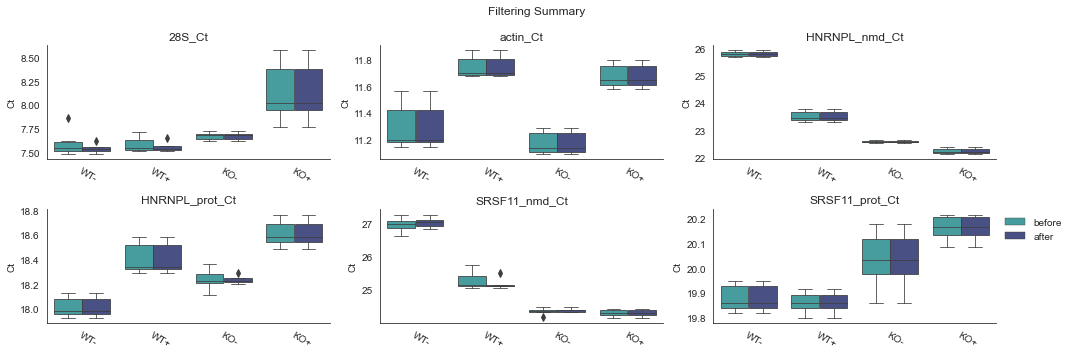

In [9]:
fig = iqrfilter.plot(figsize=(15,5))

Note how this time the two figures actually show differences between pre- and post-filtered datasets. That is because the `IQRFilter` is not bound by the static +-1 range of the `RangeFilter` but will dynamically filter out according to the spread of the data. 

Then why are there "new outliers" in the Post-Filter Summary?? Well, we assemble a new Boxplot from the reduced data here, so the median and first and third quartiles will be re-calculated which may result in "new outliers" as the reference parameters have changed. However, this is just from the plotting method.

### 2.5 Finishing up
From here on it's just business as usual to get the data from the analysis, just as in the first tutorial. Since this has nothing to do with the Filters per se, we will stop at this point.

You are now able to use the `qpcr.Filters` in both the pre-implemented `BasicPlus` pipeline and in your own manually assembled pipeline. Good job! 